In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
id = "1-A1WWZEo_NUOp3-uxU8in5Z1e0vw6ucn"

In [5]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test_data')  

In [6]:
test_data = pd.read_pickle("test_data")

In [15]:
test_data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,lemmatized_comment,lemmatized_parent_comment,clean_comment,clean_parent_comment,lemmatized_clean_comment,lemmatized_clean_parent_comment,vectorized_comment,vectorized_clean_comment,vectorized_parent_comment,vectorized_clean_parent_comment,dirty_cosine_similarity,clean_cosine_similarity,word_count,punctuation_count,has_repeated,exclaim_count,qns_mark_count,ellipses_mark_count,interjection_count,laughter_words_count,capitalized_word_count,partial_capital_word_count,emoticon_count,sentiment
794682,1,Racist comments are really rare on the interne...,Targash,news,6.0,6.0,0.0,2014-06,11/6/14 16:02,"perhaps it is your bias dear redditor, and non...",Racist comment really rare internet 's clearly...,"perhaps bias dear redditor , none .",Racist comments are really rare on the interne...,perhaps it is your bias dear redditor and none...,Racist comment really rare internet clearly re...,perhaps bias dear redditor none,"[-0.2260461, -0.5411476, -0.5956079, 1.6732603...","[-0.5515428, -0.59989977, 0.069325216, 1.59275...","[-0.24906166, -0.65218884, 0.12795807, 0.64601...","[-0.33440658, -0.508268, 0.3577558, 0.4706608,...",0.250085,0.188576,27,2,0,0,0,0,0,0,0,0,0,neg
1003517,0,"yes, if good taste is what a cock doodle shoul...",superfusion1,sex,8.0,8.0,0.0,2011-01,19/1/11 15:32,That's the most tasteful video I have ever see...,"yes , good taste cock doodle , let cock doodle .",That 's tasteful video I ever see cock doodle .,yes if good taste is what a cock doodle should...,Thats the most tasteful video I have ever seen...,yes good taste cock doodle let cock doodle,Thats tasteful video I ever see cock doodle,"[-0.7737616, 0.4774656, 0.13742262, 0.18524809...","[-0.76534796, 0.46344534, -0.03482504, -0.1605...","[-0.19669841, 0.023759527, 0.39963058, -0.1046...","[-0.32654247, 0.2684772, 0.13918118, 0.0023651...",0.249204,0.183911,18,3,0,0,0,0,0,0,0,0,0,pos
526207,1,Totally not photoshopped...,RB30DETT,funny,11.0,11.0,0.0,2015-12,11/12/15 17:29,London Underground,Totally photoshopped ...,London Underground,Totally not photoshopped,London Underground,Totally photoshopped,London Underground,"[-0.14899243, -0.19366069, -0.20084605, 0.6875...","[-0.11780262, -0.2061242, 0.010147771, 0.53536...","[0.20910913, -0.055749796, 0.017575901, 0.4827...","[0.11732921, -0.14933924, 0.042169612, 0.49933...",0.760832,0.762000,3,3,0,0,0,1,0,0,0,0,0,neu
169751,1,"No, there's too much sexism in those industrie...",randomcombination102,TumblrInAction,50.0,-1.0,-1.0,2016-12,18/12/16 2:17,"Yeah, it's much easier to bitch about male pri...","No , 's much sexism industry make dangerous wo...","Yeah , 's much easy bitch male privilege inter...",No theres too much sexism in those industries ...,Yeah its much easier to bitch about male privi...,No there much sexism industry make dangerous w...,Yeah much easy bitch male privilege internet l...,"[0.24865268, 0.7403738, 0.05449423, 0.81168157...","[0.31113982, 1.0847201, 0.07776833, 0.32138768...","[-0.6251248, -0.3786881, 0.0020529833, 1.26597...","[-0.52135706, -0.47163898, -0.053898532, 1.226...",0.222351,0.213574,18,3,0,0,0,0,0,0,0,0,0,neg
585774,0,Maybe they should take a leaf from the lending...,MemorableYetUnique,unitedkingdom,1.0,1.0,0.0,2015-10,19/10/15 20:15,It's because they specifically want to offer l...,Maybe take leaf lending industry 's playbook o...,It 's specifically want offer loss-making ( bo...,Maybe they should take a leaf from the lending...,Its because they specifically want to offer lo...,Maybe take leaf lending industry playbook offe...,Its specifically want offer lossmaking bookie ...,"[0.022282721, 0.008266672, 0.74342155, 0.85941...","[0.8069845, 0.17959124, 0.5259561, 1.3175151, ...","[-1.6010864, 1.8231604, -0.28390932, 0.6216357...","[-2.014457, 2.110243, -0.8449971, 1.1744075, 0...",0.192439,0.108372,21,9,0,0,0,1,0,0,0,1,0,neu


In [16]:
test_data.shape

(202166, 34)

In [17]:
id = "1hDy1SadRQ-Bjqh7tPiPDNucWlNRymVgh"

In [18]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('svm_pred')  

In [19]:
with open('svm_pred', 'rb') as f:
    svm_pred = np.load(f)

In [20]:
id = '1o7JM3oaK1wn_Wh4kmidC0yQ04B9G70ut'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('forest_pred')  

In [21]:
with open('forest_pred', 'rb') as f:
    forest_pred = np.load(f)

In [22]:
id = '1WECoXjlaf8Uifiw5u5T3gVn92RJQI5FZ'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('xgb_pred')  

In [23]:
with open('xgb_pred', 'rb') as f:
    xgb_pred = np.load(f)

In [24]:
test_data['svm'] = svm_pred 
test_data['forest'] = forest_pred
test_data['xgb'] = xgb_pred

In [25]:
counts =['word_count',
       'punctuation_count', 'has_repeated', 'exclaim_count', 'qns_mark_count',
       'ellipses_mark_count', 'interjection_count', 'laughter_words_count',
       'capitalized_word_count', 'partial_capital_word_count',
       'emoticon_count']

In [26]:
len(counts)

11

# Plots

In [27]:
predictors= ['svm','forest','xgb']

# Counts greater than mean

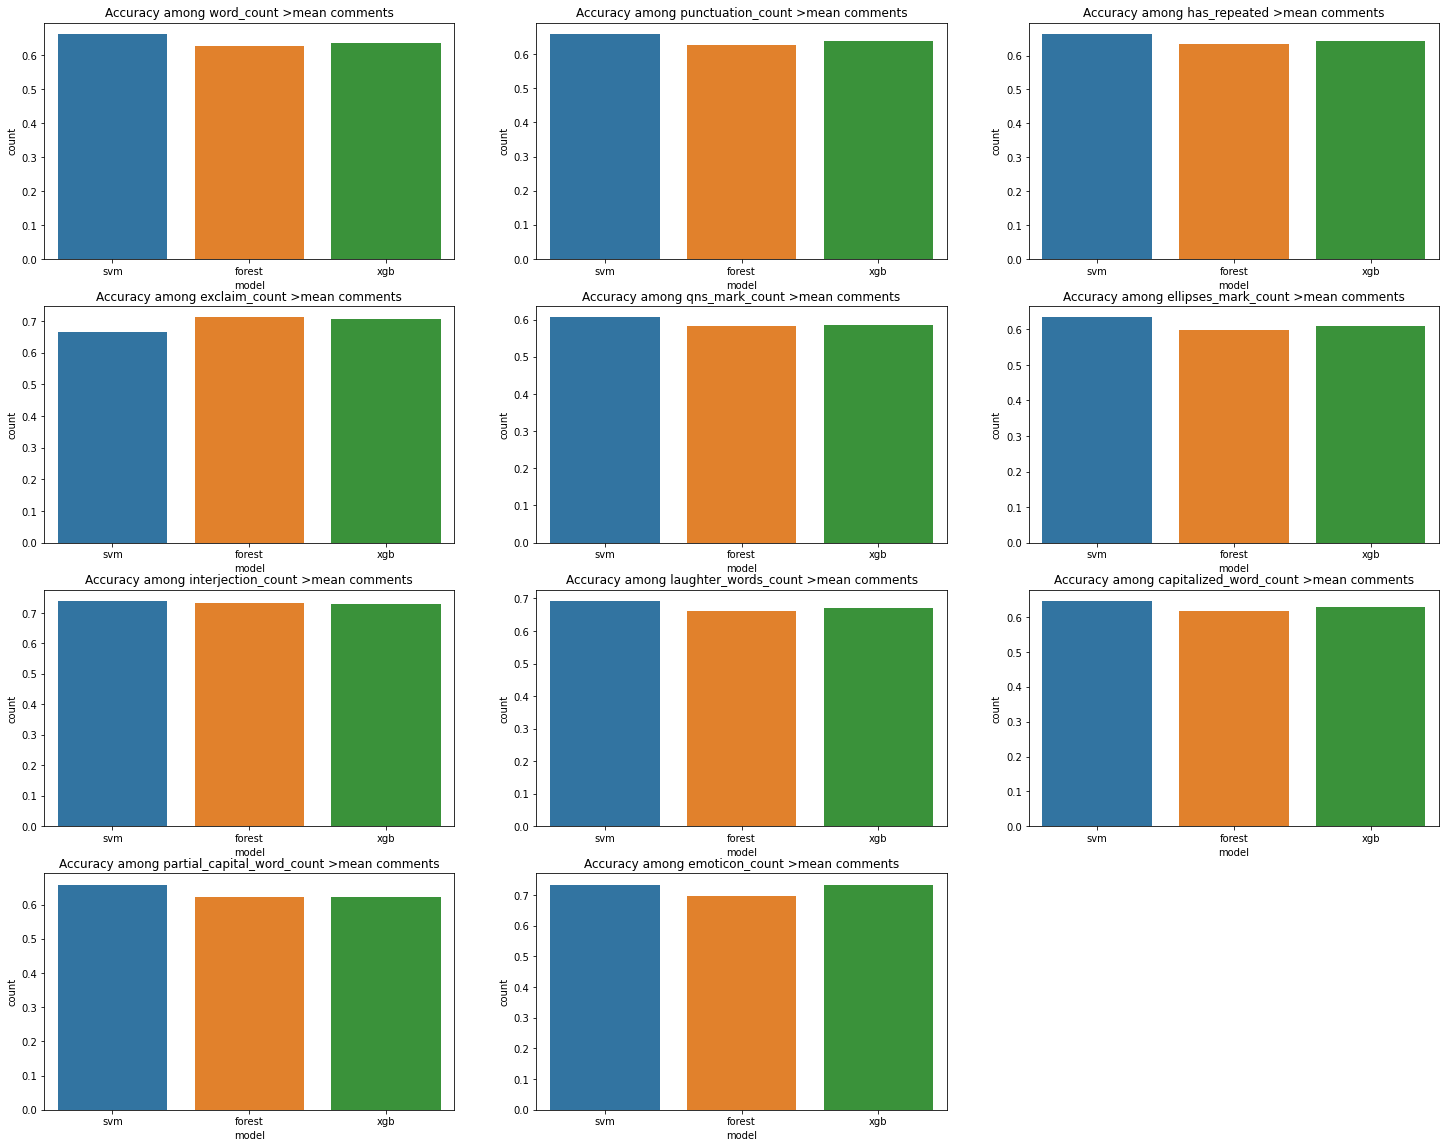

In [39]:
plt.figure(figsize=(25,20))
k=1
for j in counts:
  exclaim = test_data[test_data[j]>test_data[j].mean()]
  exclaim_res=[]
  for i in predictors:
    exclaim1 = exclaim[exclaim[i] == exclaim['label']]
    exclaim_res.append(len(exclaim1))
  #print(exclaim_res)
  exclaim_df = pd.DataFrame({'model':predictors,'count':exclaim_res})
  exclaim_df['count'] = exclaim_df['count']/len(exclaim)
  plt.subplot(4,3,k)
  sns.barplot(x='model',y='count',data=exclaim_df).set_title("Accuracy among "+ j +" >mean comments")
  k+=1


[78997, 76493, 77021]
[92710, 89158, 89944]
[129814, 124502, 125815]
[118613, 112351, 113785]
[117147, 112315, 113573]
[122483, 117610, 118777]
[123812, 118490, 119857]
[128308, 123060, 124347]
[116382, 111624, 112755]
[130153, 124835, 126174]
[129511, 124217, 125461]


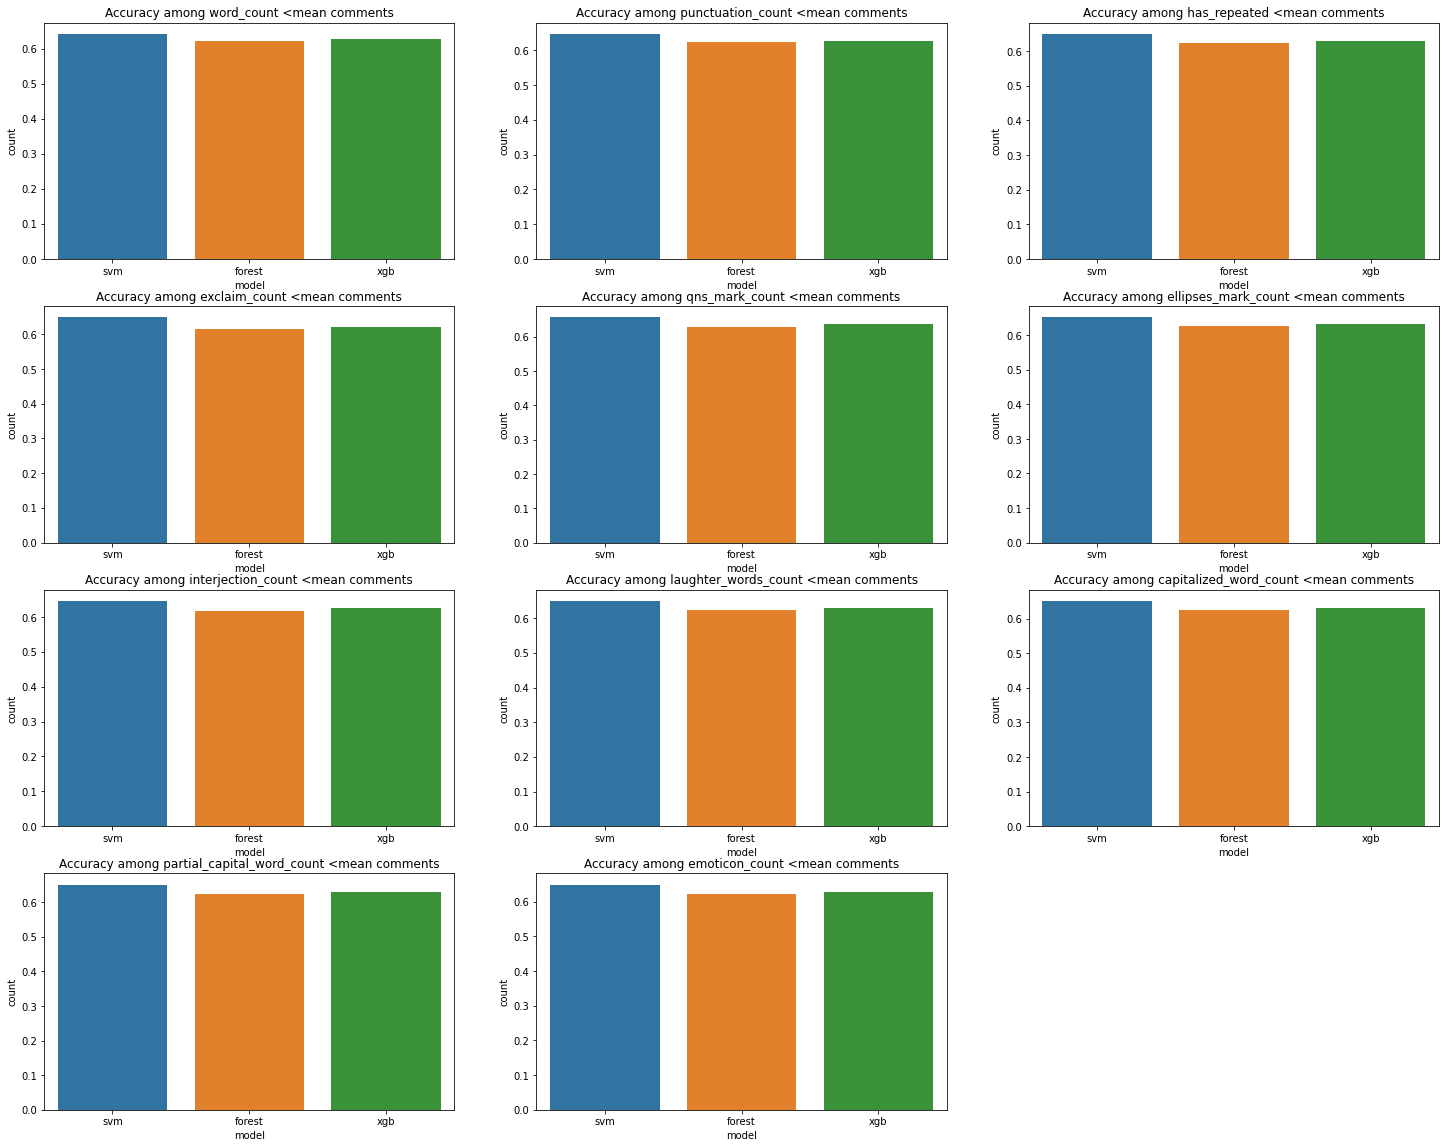

In [29]:
plt.figure(figsize=(25,20))
k=1
for j in counts:
  exclaim = test_data[test_data[j]<test_data[j].mean()]
  exclaim_res=[]
  for i in predictors:
    exclaim1 = exclaim[exclaim[i] == exclaim['label']]
    exclaim_res.append(len(exclaim1))
  print(exclaim_res)
  exclaim_df = pd.DataFrame({'model':predictors,'count':exclaim_res})
  exclaim_df['count'] = exclaim_df['count']/len(exclaim)
  plt.subplot(4,3,k)
  sns.barplot(x='model',y='count',data=exclaim_df).set_title("Accuracy among "+ j +" <mean comments")
  k+=1

# subreddit

For each predictor, do they have different performance on different subreddit?
Remove subreddits that have less than mean comments

In [30]:
np.mean(test_data.groupby("subreddit").apply(len).reset_index(name='count'))

count    26.618302
dtype: float64

In [31]:
all_subs = test_data.groupby('subreddit').agg(counts2=('subreddit','count'))
sum(all_subs['counts2']>26) #797
all_subs = all_subs[all_subs['counts2']>=26]

In [32]:
all_subs

,counts2
subreddit,
2007scape,623
3DS,78
49ers,90
4chan,227
AFL,112
...,...
wow,782
xboxone,510
youtubehaiku,69


In [33]:
sub_data = test_data[test_data['subreddit'].isin(all_subs.index)]

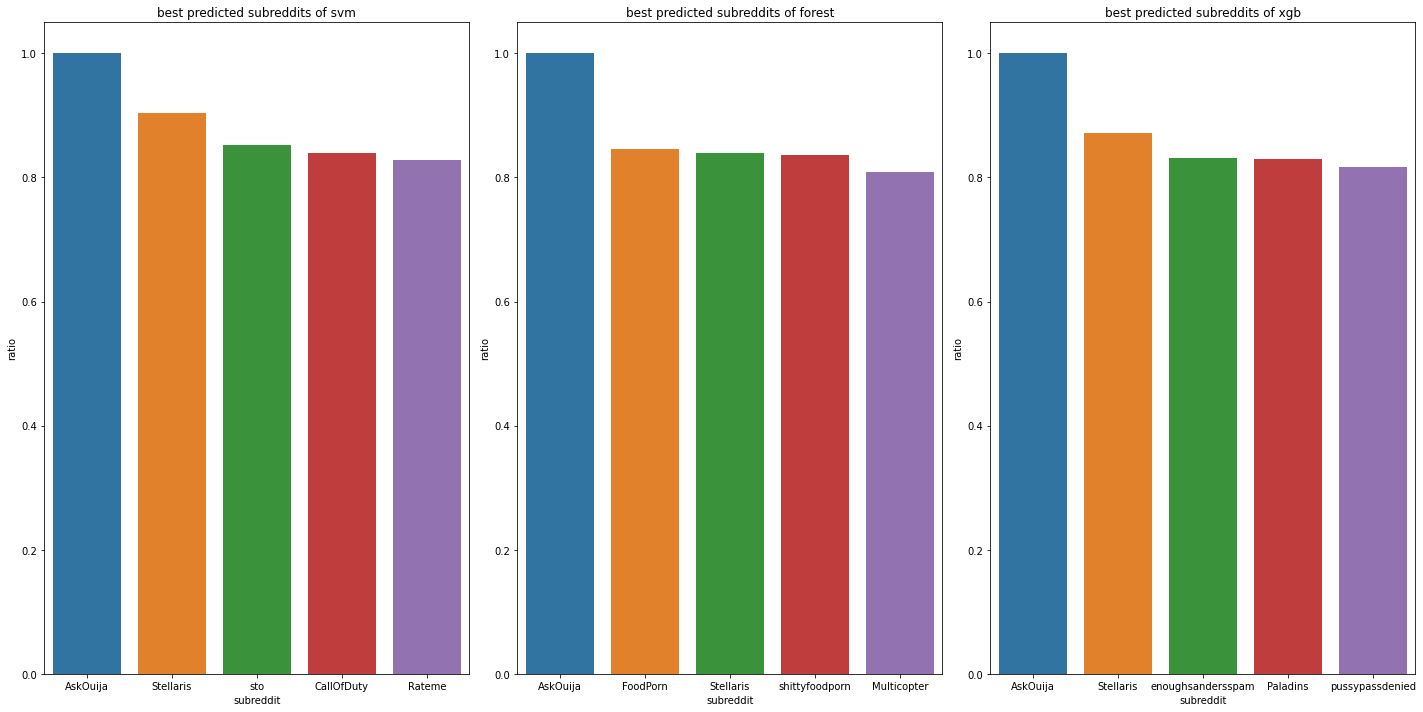

In [37]:
plt.figure(figsize=(20,10))
k=1
for i in predictors:
  sub_df = sub_data[sub_data[i] == sub_data['label']].groupby('subreddit').agg(counts=('subreddit','count'))
  sub_df['ratio'] = sub_df['counts']/all_subs['counts2']
  sub_df = sub_df.sort_values(by='ratio',ascending=False)
  sub_df['subreddit']=sub_df.index
  plt.subplot(1,3,k)
  sns.barplot(x=sub_df['subreddit'][0:5],y=sub_df['ratio']).set_title("best predicted subreddits of "+i)
  k+=1
plt.tight_layout()

In [ ]:
test_data[test_data['subreddit']=="AskOuija"]

,index,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,lemmatized_comment,lemmatized_parent_comment,clean_comment,clean_parent_comment,lemmatized_clean_comment,lemmatized_clean_parent_comment,vectorized_comment,vectorized_clean_comment,vectorized_parent_comment,vectorized_clean_parent_comment,cosine_similarity_dirty_comments,cosine_similarity_clean_comments,word_count,punctuation_count,has_repeated,exclaim_count,qns_mark_count,ellipses_mark_count,interjection_count,laughter_words_count,capitalized_word_count,partial_capital_word_count,emoticon_count,comment_sentiment,svc_pred,pred2
8627,12852,0,E,iiJynx,AskOuija,1.0,-1.0,-1.0,2016-11,3/11/16 7:12,C,E,C,E,C,E,C,"[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....",1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,neu,0,1
9218,90816,0,S,Youp_,AskOuija,1.0,1.0,0.0,2016-09,23/9/16 13:33,U,S,U,S,U,S,U,"[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....",1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,neu,0,0
14170,139369,0,K,Master_Grievous,AskOuija,3.0,-1.0,-1.0,2016-10,29/10/16 11:11,C,K,C,K,C,K,C,"[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....",1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,neu,0,1
15936,28145,0,/,Paidkidney,AskOuija,2.0,-1.0,-1.0,2016-10,31/10/16 2:28,F,/,F,,F,,F,"[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....",1.000000,1.000000,0.000000,0.004673,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,neu,0,0
19209,165648,0,I,1800scorpio,AskOuija,1.0,1.0,0.0,2016-09,15/9/16 0:32,N,I,N,I,N,I,N,"[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....",1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,neu,0,1
21106,197510,0,E,popinloopy,AskOuija,1.0,1.0,0.0,2016-07,12/7/16 14:15,R,E,R,E,R,E,R,"[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....",1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,neu,0,0
22346,251644,0,D,fishfishfish,AskOuija,1.0,1.0,0.0,2016-07,8/7/16 21:31,A,D,A,D,A,D,A,"[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....",1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,neu,0,0
32324,167577,0,I,NattyBroh,AskOuija,1.0,-1.0,-1.0,2016-11,24/11/16 15:57,L,I,L,I,L,I,L,"[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....",1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,neu,0,1
50295,189276,0,M,metaranha,AskOuija,1.0,1.0,0.0,2016-07,26/7/16 11:33,I,M,I,M,I,M,I,"[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....","[0.00048813503, 0.0021518937, 0.0010276338, 0....",1.000000,1.000000,0.000000,0.000000,0.0,0.

In [38]:
test_data[test_data['subreddit']=="Stellaris"]

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,lemmatized_comment,lemmatized_parent_comment,clean_comment,clean_parent_comment,lemmatized_clean_comment,lemmatized_clean_parent_comment,vectorized_comment,vectorized_clean_comment,vectorized_parent_comment,vectorized_clean_parent_comment,dirty_cosine_similarity,clean_cosine_similarity,word_count,punctuation_count,has_repeated,exclaim_count,qns_mark_count,ellipses_mark_count,interjection_count,laughter_words_count,capitalized_word_count,partial_capital_word_count,emoticon_count,sentiment,svm,forest,xgb
386236,0,#cylonsdidnothingwrong,kittenparry,Stellaris,4.0,4.0,0.0,2016-04,2/4/16 15:36,Stellaris Gameplay Footage From GDC 2016 court...,# cylonsdidnothingwrong,Stellaris Gameplay Footage From GDC 2016 court...,cylonsdidnothingwrong,Stellaris Gameplay Footage From GDC 2016 court...,cylonsdidnothingwrong,Stellaris Gameplay Footage From GDC 2016 court...,"[-0.0027935968, 0.002013312, 0.00477007, 0.001...","[-0.0027935968, 0.002013312, 0.00477007, 0.001...","[0.30505478, -0.5145944, -0.0039239526, 1.2213...","[0.39559394, -0.09422528, -0.07828962, 1.06309...",0.031275,0.017753,1,1,0,0,0,0,0,0,0,0,0,neu,0,0,0
43145,0,"Most likely the ""Star Wars: A Galaxy Divided"" ...",Firefox9890,Stellaris,52.0,-1.0,-1.0,2016-12,1/12/16 0:47,"Glory to the empire! Also, what mods did you u...",Most likely `` Star Wars : A Galaxy Divided ''...,"Glory empire ! Also , mod use ?",Most likely the Star Wars A Galaxy Divided mod...,Glory to the empire Also what mods did you use...,Most likely Star Wars A Galaxy Divided mod col...,Glory empire Also mod use,"[0.16401212, -0.6519977, 0.15500115, 0.9862056...","[-0.10592897, -0.28446737, 0.33214834, 0.87007...","[0.8656432, -0.3858469, -0.10015781, 0.6545514...","[0.80611205, -0.47189885, 0.009476582, 0.63063...",0.478223,0.415017,14,4,0,0,0,0,0,0,0,0,0,neg,0,0,0
380944,1,what game tutorial?,morganrbvn,Stellaris,4.0,4.0,0.0,2016-02,23/2/16 1:31,"Of the Paradox games, EU4 imo is easier. Watch...",game tutorial ?,"Of Paradox game , EU4 imo easy . Watch Arumba ...",what game tutorial,Of the Paradox games EU4 imo is easier Watch A...,game tutorial,Of Paradox game EU4 imo easy Watch Arumbas LPs...,"[0.0076118894, -0.25705734, 0.12513873, 0.3050...","[-0.0056552663, -0.060224157, 0.07217789, 0.33...","[1.2681968, -0.3922372, -0.15295714, 0.1601122...","[0.9747686, -0.5522518, -0.14810032, -0.261237...",0.302816,0.274094,3,1,0,0,1,0,0,0,0,0,0,neu,1,1,1
227919,0,Self-hating spiritual robots is a feature and ...,Galle_,Stellaris,7.0,7.0,0.0,2016-06,12/6/16 22:33,"Well, now we know what's eating those Spiritua...",Self-hating spiritual robot feature I want sta...,"Well , know 's eat Spiritual Robots .",Selfhating spiritual robots is a feature and I...,Well now we know whats eating those Spiritual ...,Selfhating spiritual robot feature I want stay...,Well know whats eat Spiritual Robots,"[-0.14045888, 0.2756334, -0.47127074, 0.646887...","[-0.23915884, -0.26873308, -0.08929269, 0.5455...","[-0.17705916, -0.78179187, 0.61653656, -0.0632...","[-0.5162773, -0.8500525, 0.629791, -0.00033120...",0.033344,-0.021279,16,2,0,0,0,0,0,0,0,0,0,pos,0,1,1
298478,0,I'd say give the federation an energy/mineral ...,Quatsum,Stellaris,4.0,4.0,0.0,2016-05,19/5/16 13:12,Do you not see how 20% of total income and nav...,I 'd say give federation energy/mineral stockp...,Do see 20 % total income naval capacity comple...,Id say give the federation an energymineral st...,Do you not see how 20 of total income and nava...,Id say give federation energymineral stockpile...,Do see 20 total income naval capacity complete...,"[-0.23695849, -0.14628297, -0.094565436, 0.477...","[-0.36922038, 0.017981734, 0.06315928, 0.31874...","[0.10261627, 0.24197765, 0.16959856, 0.881162,...","[-0.17277381, 0.4351117, 0.24201407, 0.7460136...",0.094219,0.116040,26,5,0,0,0,0,0,0,0,0,0,pos,0,0,0
214827,1,Somalia?,Ornlu_Wolfjarl,Stellaris,3.0,3.0,0.0,2016-05,9/5/16 7:58,Something politicall

# True positives and false positives of each model

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

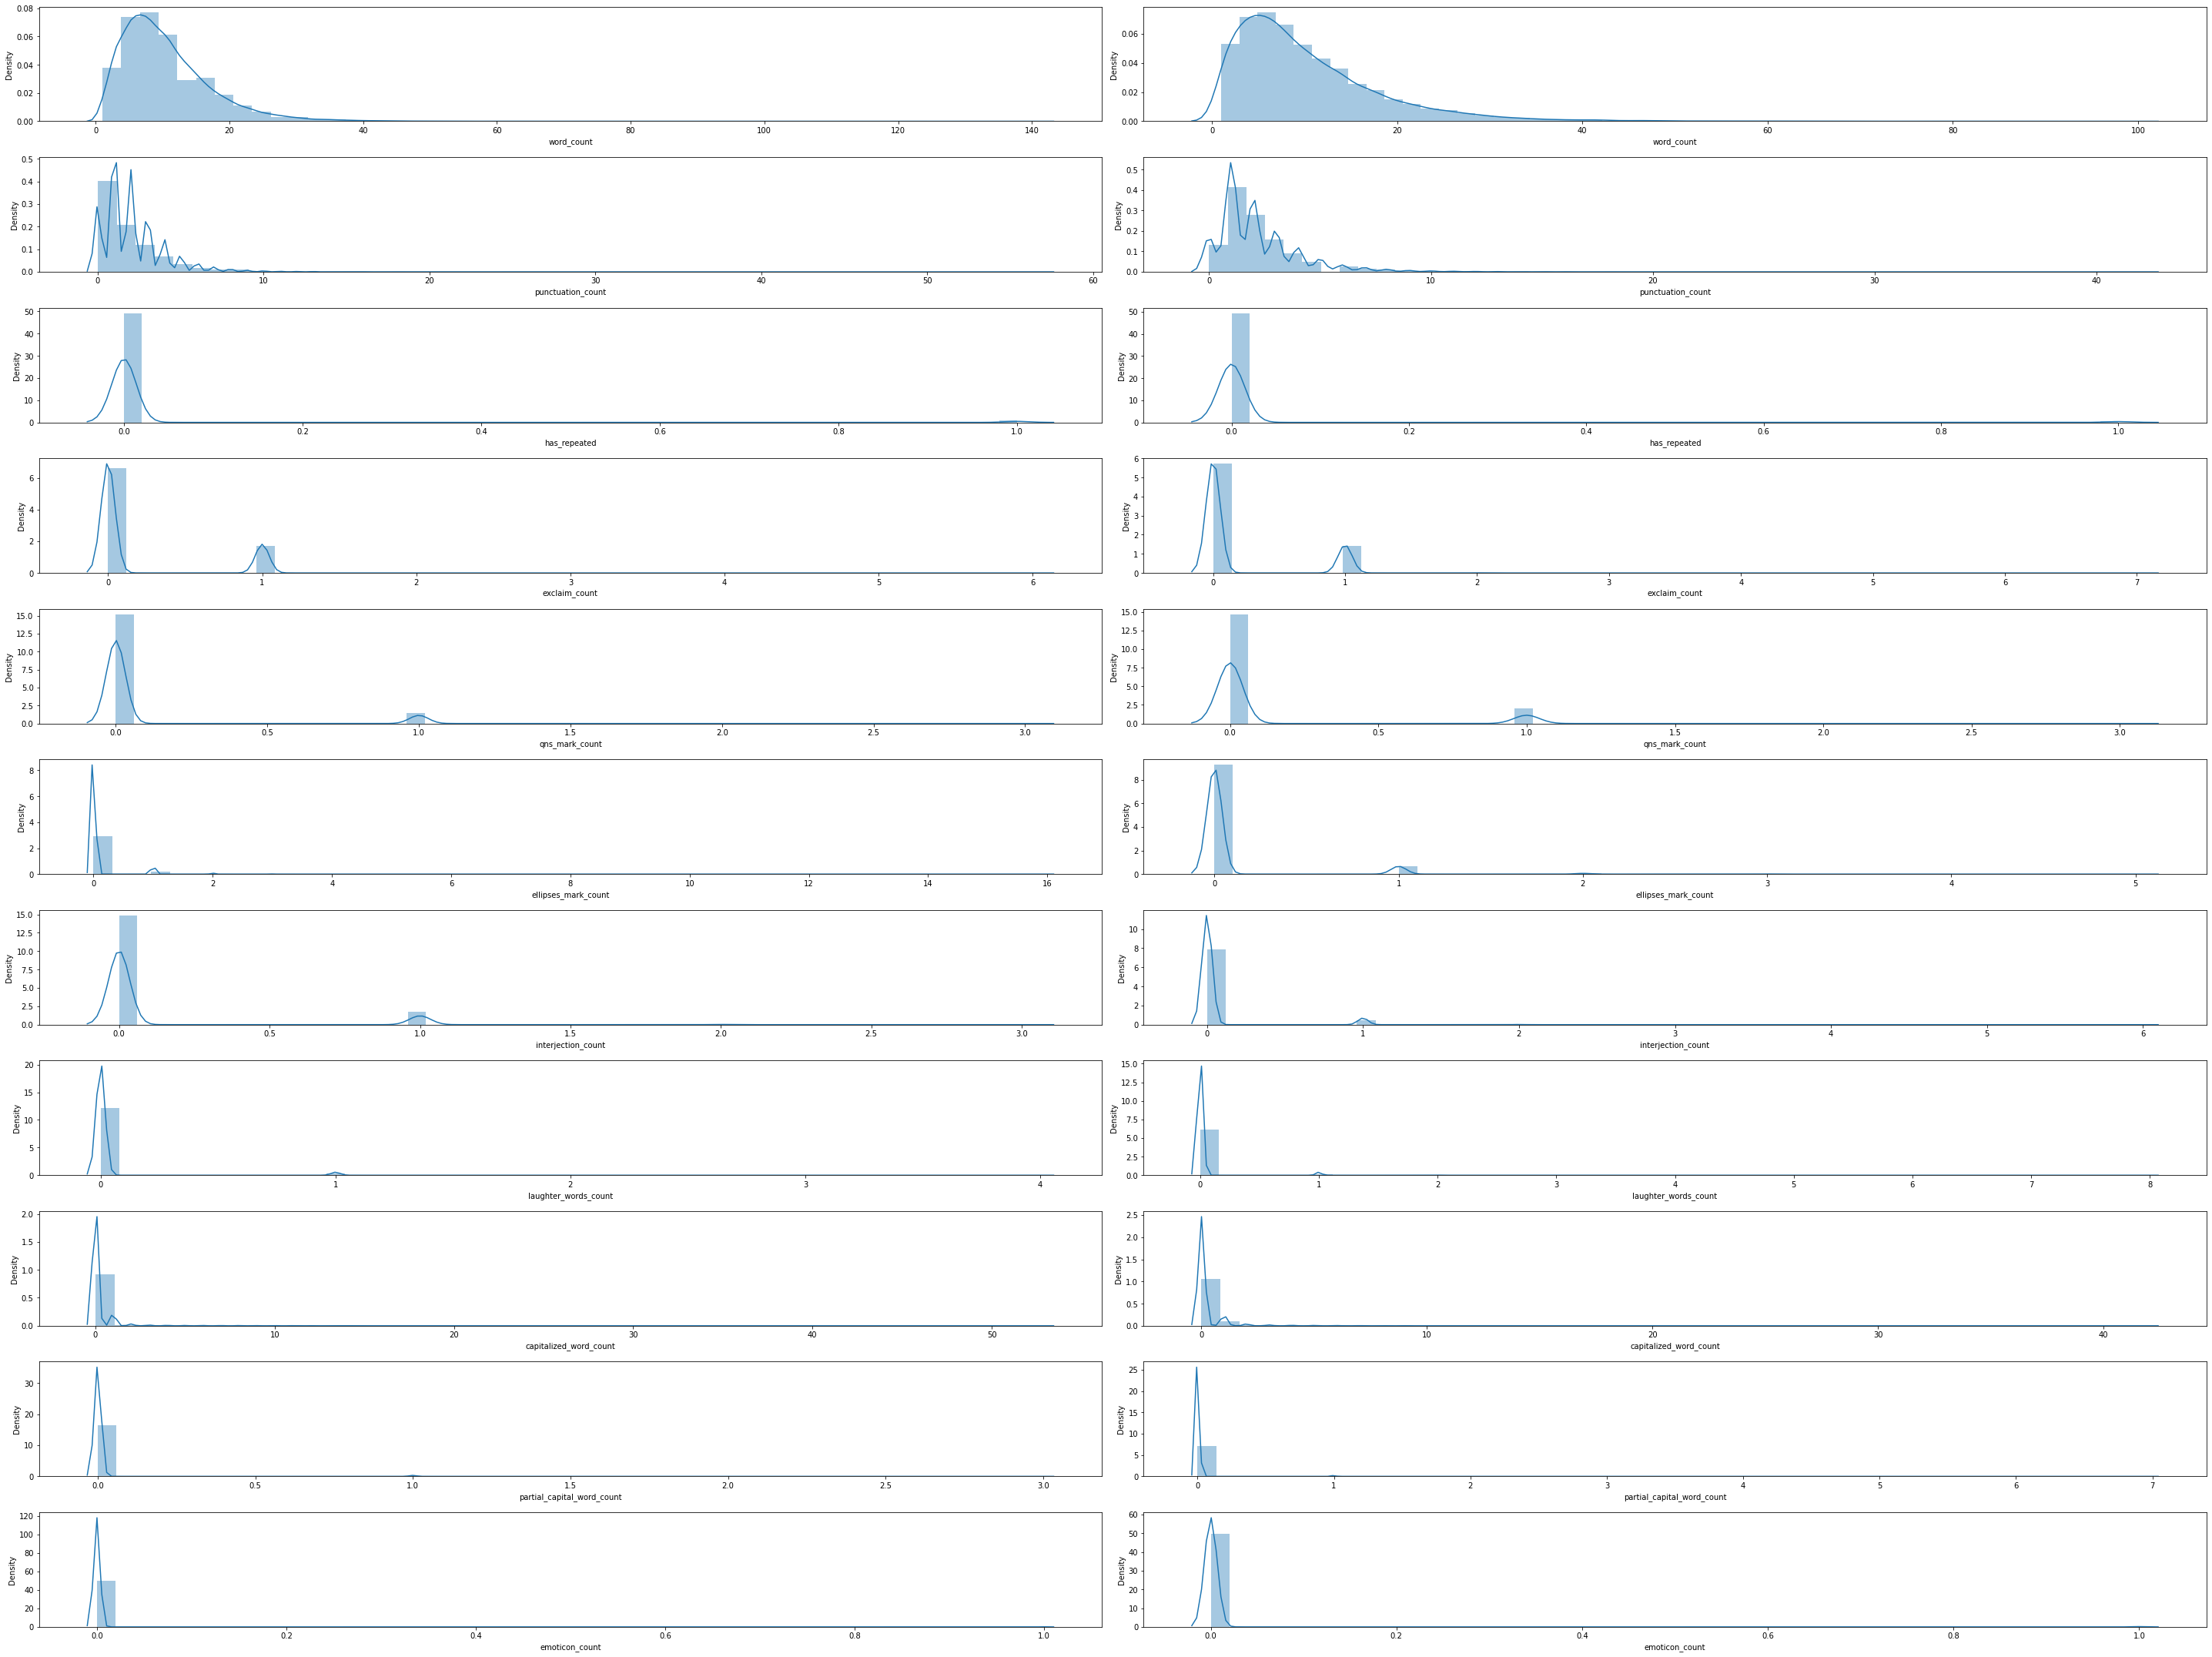

In [29]:
tp = test_data[(test_data['svm']==1) & (test_data['label']==1)] 
fp = test_data[(test_data['svm']==1) & (test_data['label']==0)]
plt.figure(figsize=(40,30))
k=1
for i in counts:
  plt.subplot(11,2,k)
  sns.distplot(tp[i])
  plt.subplot(11,2,k+1)
  sns.distplot(fp[i])
  k+=2
plt.tight_layout()

KeyError: ignored

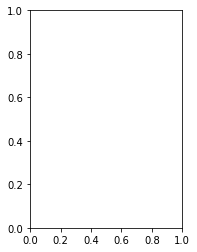

In [30]:
# exclaim_count
plt.subplot(1,2,1)
sns.countplot(test_data[(test_data['pred1']==1) & (test_data['label']==1)]['exclaim_count']>test_data[(test_data['pred1']==1) & (test_data['label']==1)]['exclaim_count'].mean()).set_title('number of exclaim_count greater than mean for model1')
plt.subplot(1,2,2)
sns.countplot(test_data[(test_data['pred2']==1) & (test_data['label']==1)]['exclaim_count']>test_data[(test_data['pred2']==1) & (test_data['label']==1)]['exclaim_count'].mean()).set_title('number of exclaim_count greater than mean for model2')

In [ ]:
sum(test_data[(test_data['pred1']==1) & (test_data['label']==1)]['exclaim_count']>test_data[(test_data['pred1']==1) & (test_data['label']==1)]['exclaim_count'].mean())

6388

In [ ]:
sum(test_data[(test_data['pred2']==1) & (test_data['label']==1)]['exclaim_count']>test_data[(test_data['pred2']==1) & (test_data['label']==1)]['exclaim_count'].mean())

6469

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


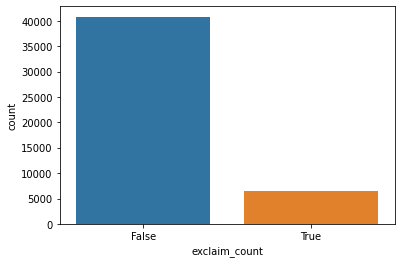

In [ ]:
sns.countplot(test_data[(test_data['pred1']==1) & (test_data['label']==1)]['exclaim_count']>test_data[(test_data['pred1']==1) & (test_data['label']==1)]['exclaim_count'].mean())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'number of exclaim_count greater than mean')

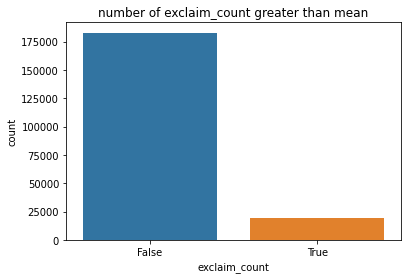

In [ ]:
sns.countplot(test_data['exclaim_count']>test_data['exclaim_count'].mean()).set_title('number of exclaim_count greater than mean') #19300

# True negatives and False negatives

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

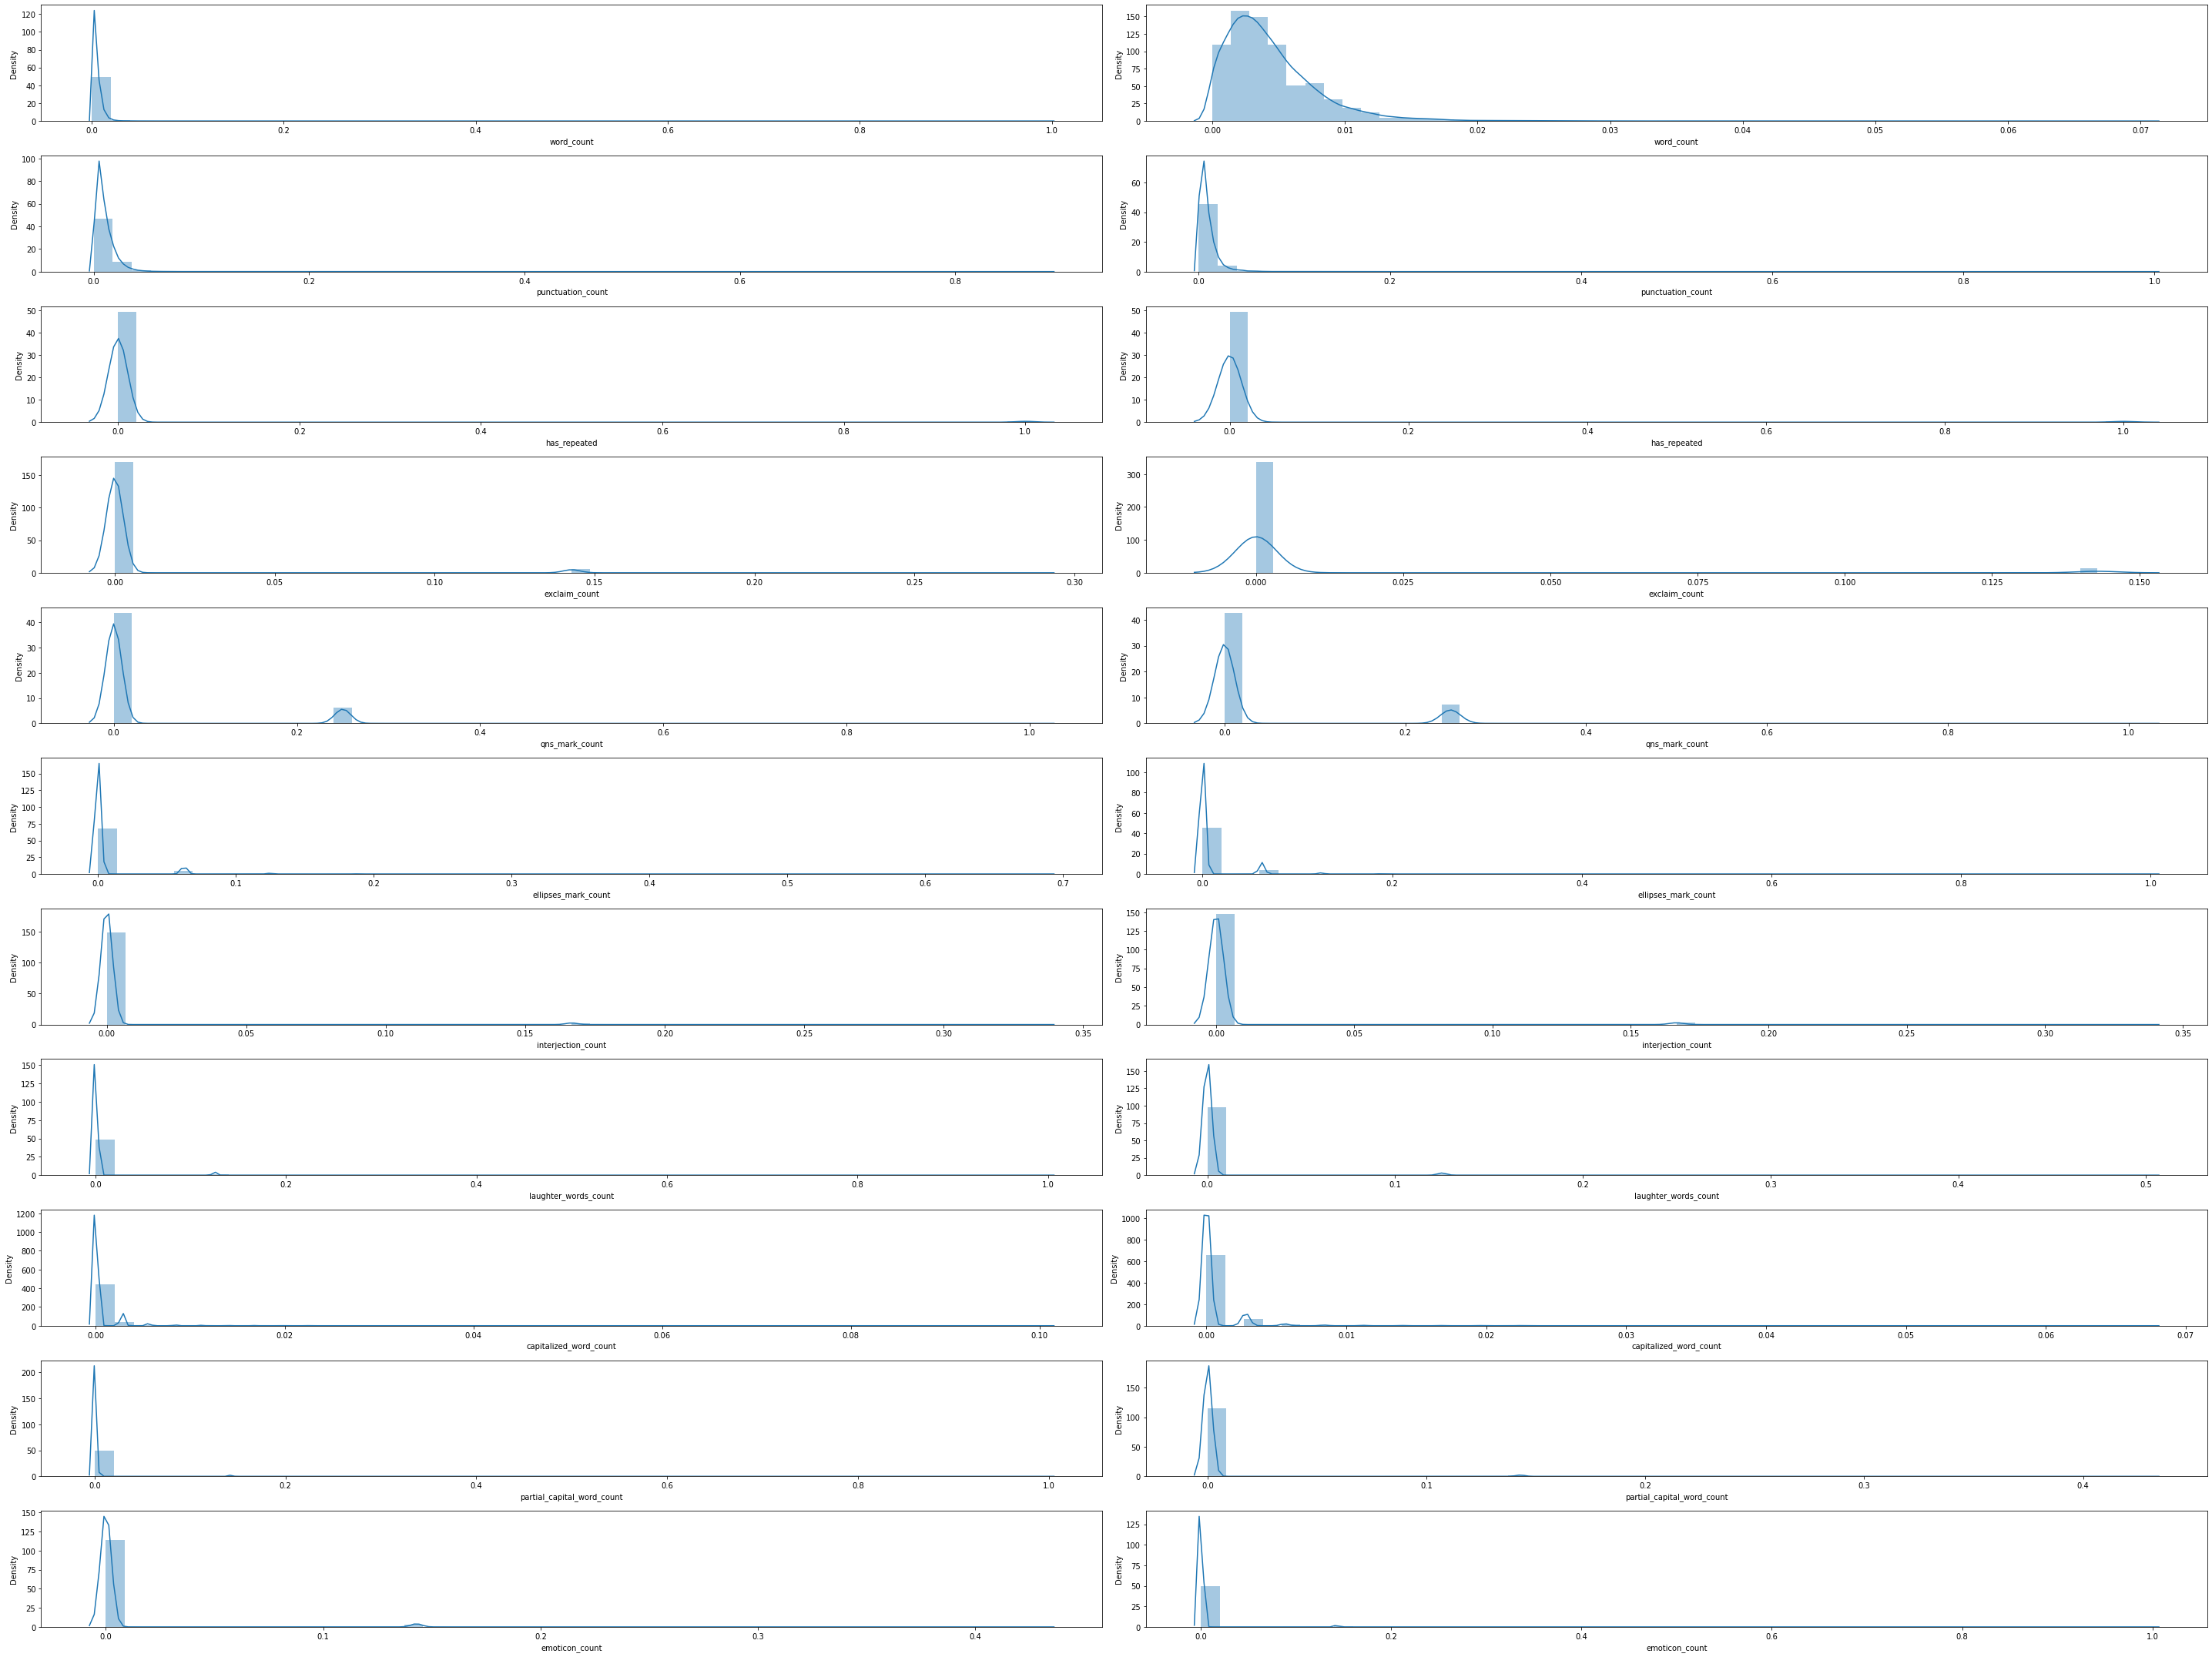

In [ ]:
tn = test_data[(test_data['svc_pred']==0) & (test_data['label']==0)] 
fn = test_data[(test_data['svc_pred']==0) & (test_data['label']==1)]
plt.figure(figsize=(40,30))
k=1
for i in counts:
  plt.subplot(11,2,k)
  sns.distplot(tn[i])
  plt.subplot(11,2,k+1)
  sns.distplot(fn[i])
  k+=2
plt.tight_layout()

# Distributions of correct predictions


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

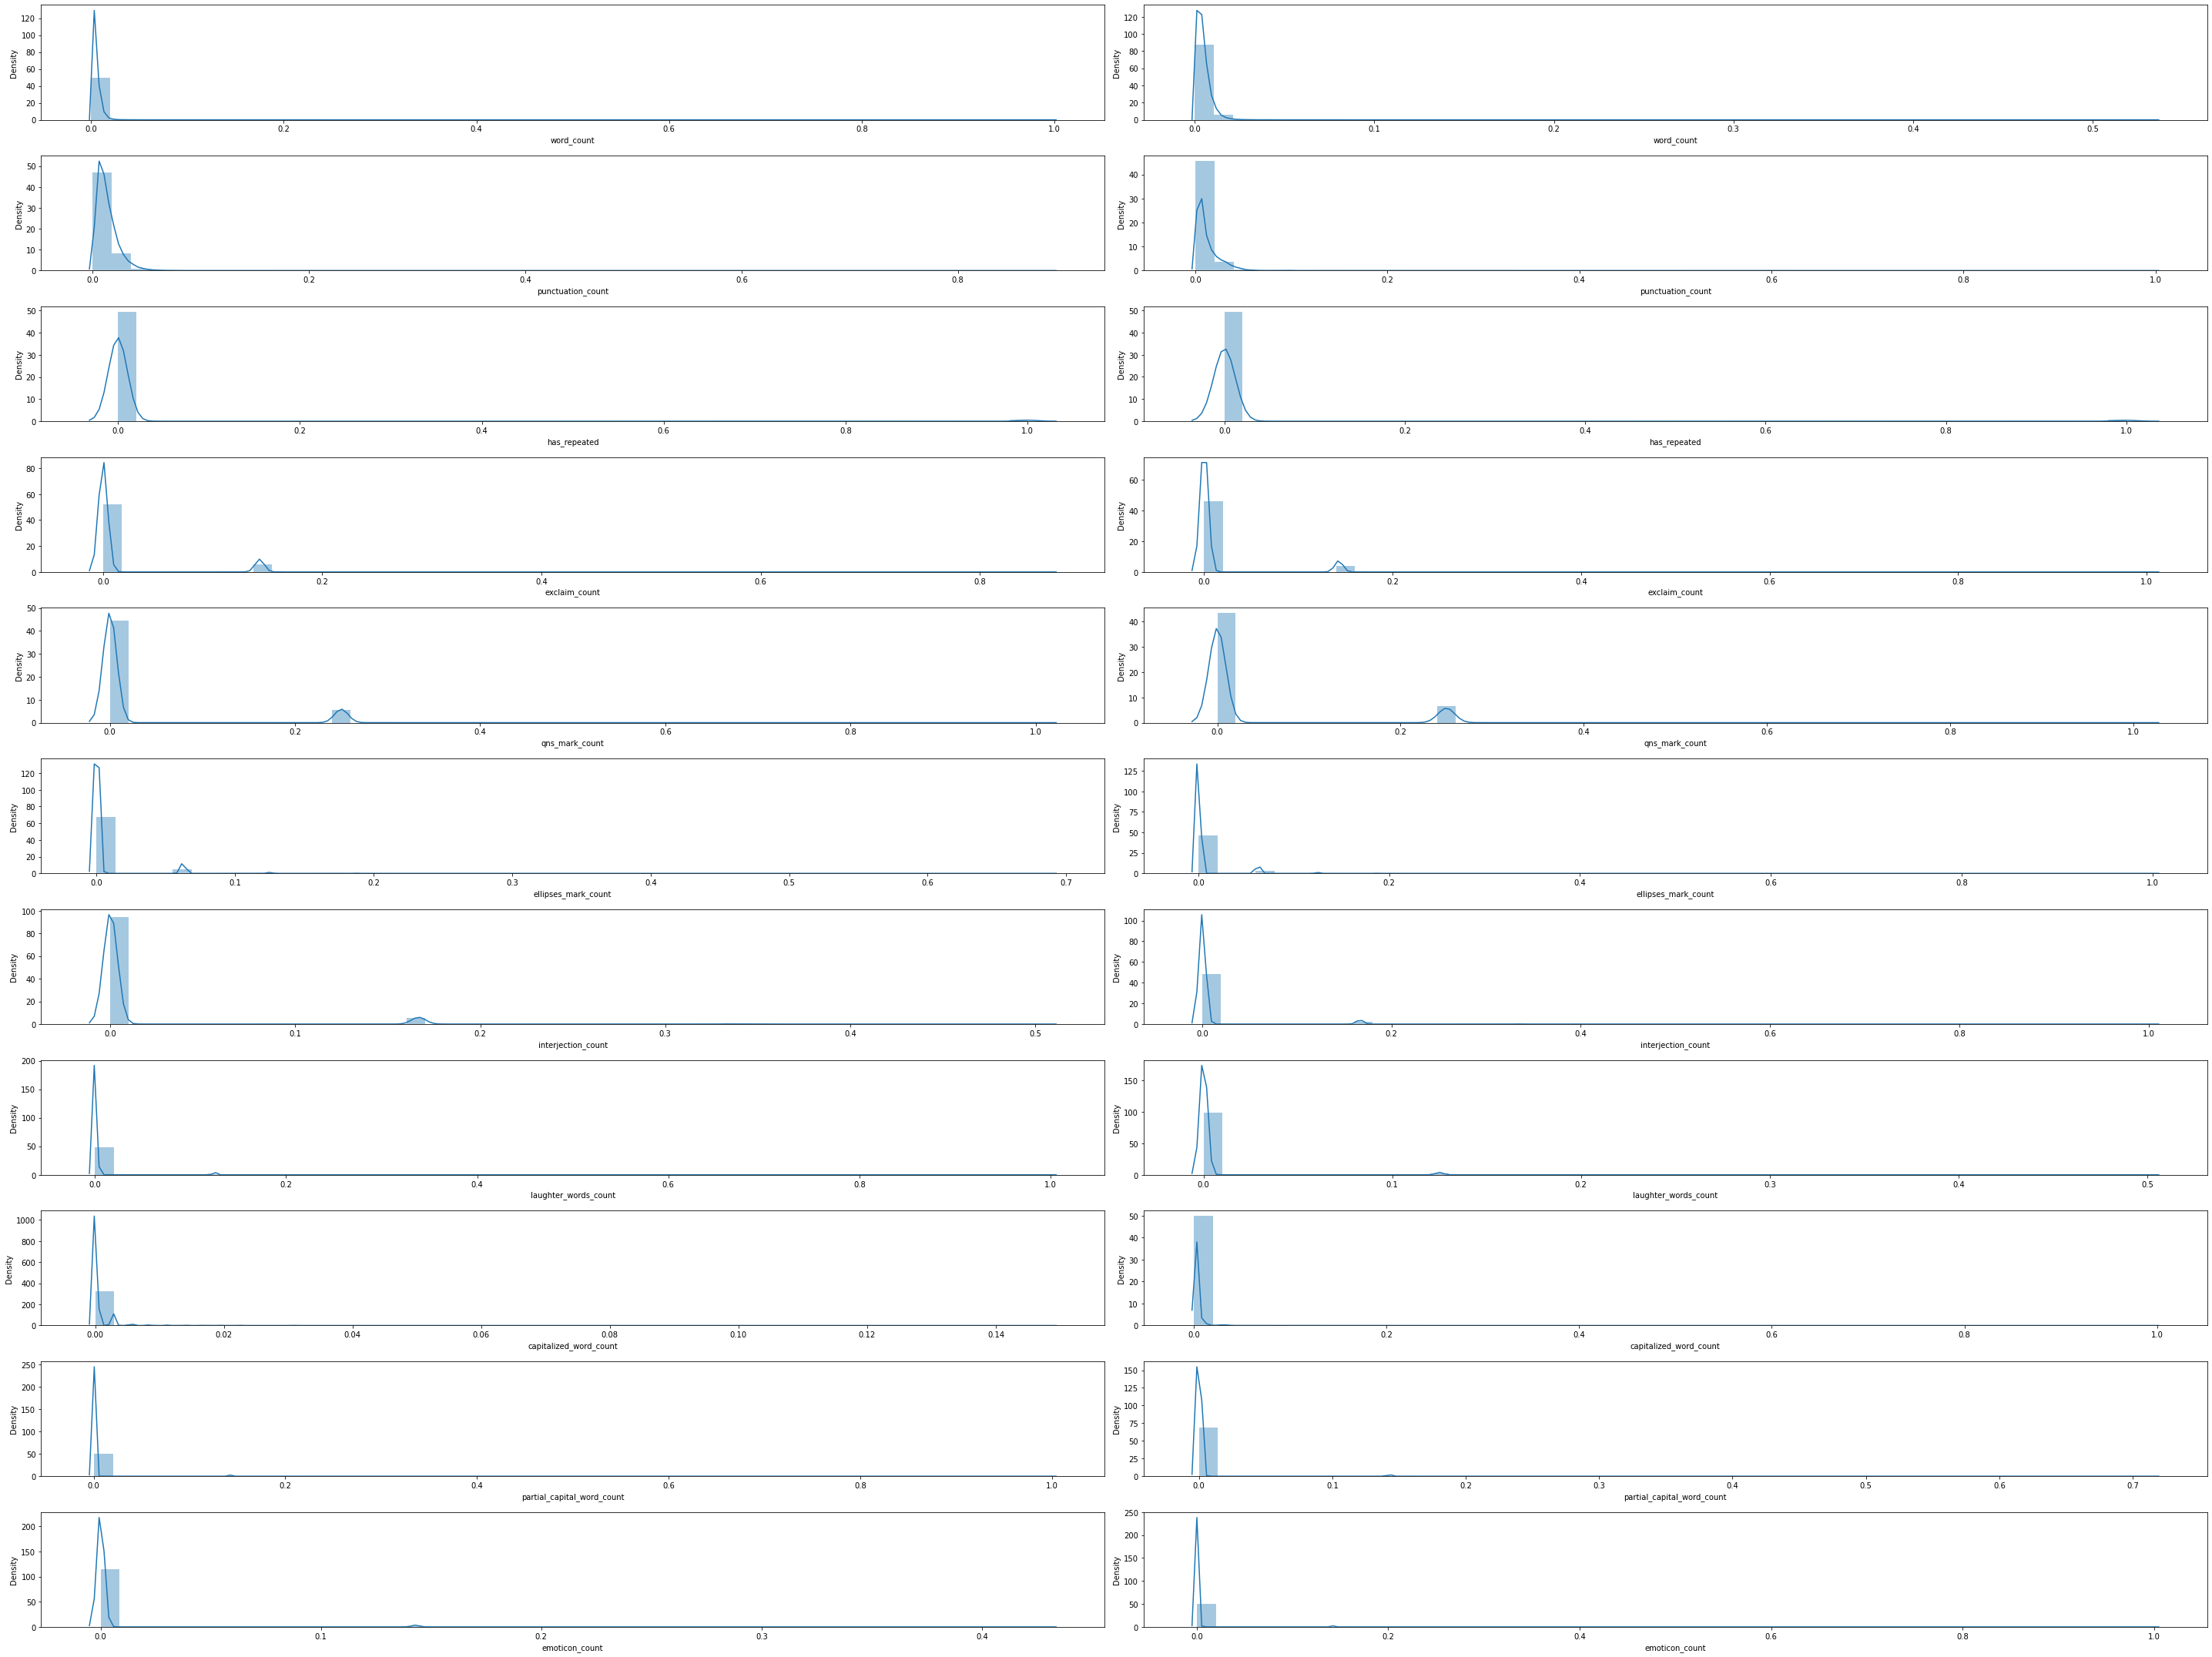

In [ ]:
correct = test_data[test_data['svc_pred']==test_data['label']] 
wrong = test_data[test_data['svc_pred']!=test_data['label']]
plt.figure(figsize=(40,30))
k=1
for i in counts:
  plt.subplot(11,2,k)
  sns.distplot(correct[i])
  plt.subplot(11,2,k+1)
  sns.distplot(wrong[i])
  k+=2
plt.tight_layout()

# count analysis

In [ ]:
TP = test_data[(test_data['svc_pred']==1) & (test_data['label']==1)] 
FN = test_data[(test_data['svc_pred']==0) & (test_data['label']==1)]

In [ ]:
FN['word_count'] = FN["comment"].apply(lambda x: len(str(x).split(" ")))
FN['char_count'] = FN["comment"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
FN['sentence_count'] = FN["comment"].apply(lambda x: len(str(x).split(".")))
FN['avg_word_length'] = FN['char_count'] / FN['word_count']
FN['avg_sentence_length'] = FN['word_count'] / FN['sentence_count']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
TP['word_count'] = TP["comment"].apply(lambda x: len(str(x).split(" ")))
TP['char_count'] = TP["comment"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
TP['sentence_count'] = TP["comment"].apply(lambda x: len(str(x).split(".")))
TP['avg_word_length'] = TP['char_count'] / TP['word_count']
TP['avg_sentence_length'] = TP['word_count'] / TP['sentence_count']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
FN.head()

,index,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,lemmatized_comment,lemmatized_parent_comment,clean_comment,clean_parent_comment,lemmatized_clean_comment,lemmatized_clean_parent_comment,vectorized_comment,vectorized_clean_comment,vectorized_parent_comment,vectorized_clean_parent_comment,cosine_similarity_dirty_comments,cosine_similarity_clean_comments,word_count,punctuation_count,has_repeated,exclaim_count,qns_mark_count,ellipses_mark_count,interjection_count,laughter_words_count,capitalized_word_count,partial_capital_word_count,emoticon_count,comment_sentiment,svc_pred,pred2,char_count,sentence_count,avg_word_length,avg_sentence_lenght,avg_sentence_length
11,964860,1,"Same, I don't share my home with those animals.",Stormbringer91,AdviceAnimals,0.0,0.0,0.0,2013-07,20/7/13 18:27,I don't know any Hepatitis patient either.,"Same , I n't share home animal .",I n't know Hepatitis patient either .,Same I dont share my home with those animals,I dont know any Hepatitis patient either,Same I dont share home animal,I dont know Hepatitis patient either,"[-0.2975953, 0.23318776, 0.85075516, -0.136142...","[-0.44621667, 0.05868047, 0.7395694, -0.040744...","[0.20189011, -0.3282676, -0.0809708, 0.1886086...","[0.44975623, -0.44955477, -0.13901035, 0.20756...",0.401361,0.297298,9,0.014019,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,neg,0,0,39,2,4.333333,4.5,4.5
15,521824,1,"k, im not talented in arts anyway :o",Zyklopi,GlobalOffensive,0.0,0.0,0.0,2015-07,2/7/15 10:12,Do not apply to any art schools while you stil...,"k , im talented art anyway :",Do apply art school still anger issue . That .,k im not talented in arts anyway,Do not apply to any art schools while you stil...,k im talented art anyway,Do apply art school still anger issue That,"[0.13765371, -0.5781274, 0.23657815, 0.1134842...","[0.13183215, -0.27573738, 0.1306485, 0.3750559...","[0.07697068, -0.25921872, 0.12750992, 0.356124...","[0.11826631, -0.31216016, 0.2519824, 0.2653959...",0.311245,0.313455,8,0.009346,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.142857,neg,0,0,29,1,3.625000,8.0,8.0
27,41439,1,"agreed, nismo juke is bae but i'm not feeling ...",MeSkata,JDM,1.0,-1.0,-1.0,2016-12,9/12/16 20:40,Nice combination of absolutely gorgeous and fu...,"agree , nismo juke bae 'm feel fd",Nice combination absolutely gorgeous fuck hide...,agreed nismo juke is bae but im not feeling th...,Nice combination of absolutely gorgeous and fu...,agree nismo juke bae im feeling fd,Nice combination absolutely gorgeous fuck hideous,"[-0.20595346, -0.37376252, 0.35717902, -0.0041...","[0.107132256, -0.48606288, 0.35070482, -0.0483...","[0.6932401, 0.07876421, 0.3536592, 0.4634916, ...","[0.6517767, -0.08643843, 0.5671862, 0.51991063...",0.385135,0.335027,11,0.009346,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,neu,0,1,42,1,3.818182,11.0,11.0
31,289478,1,My 780ti only hits 1205mhz with added voltage ...,TheRealLHOswald,nvidia,1.0,1.0,0.0,2016-06,8/6/16 15:40,My reference 780ti could hit 1320 on air with ...,My 780ti hit 1205mhz add voltage * I hate *,My reference 780ti could hit 1320 air stock bi...,My 780ti only hits 1205mhz with added voltage ...,My reference 780ti could hit 1320 on air with ...,My 780ti hit 1205mhz add voltage I hate,My reference 780ti could hit 1320 air stock bi...,"[-1.5192623, 0.121175125, -0.4892729, 0.203154...","[-1.4369817, -0.14268227, -0.37807566, 0.44396...","[0.97867054, -2.1522465, 2.1824877, -0.6379544...","[1.4819098, -1.6718122, 1.8643787, -0.3340574,...",0.355564,0.373917,11,0.009346,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,neg,0,1,48,1,4.363636,11.0,11.0
34,863418,1,These newfangled automobiles with their engine...,michaelGregoire,vim,1.0,1.0,0.0,2014-09,13/9/14 18:39,:syntax on,These newfangled automobile engine wheel crap ...,: syntax,These newfangled automobiles with their engine...,syntax on,These newfangled automobile engine wheel crap ...,syntax,"[0.7659738, -2.0573118, 0.35538575, 1.5123426,...","[0.46817, -1.9479036, -0.06

(0.0, 100.0)

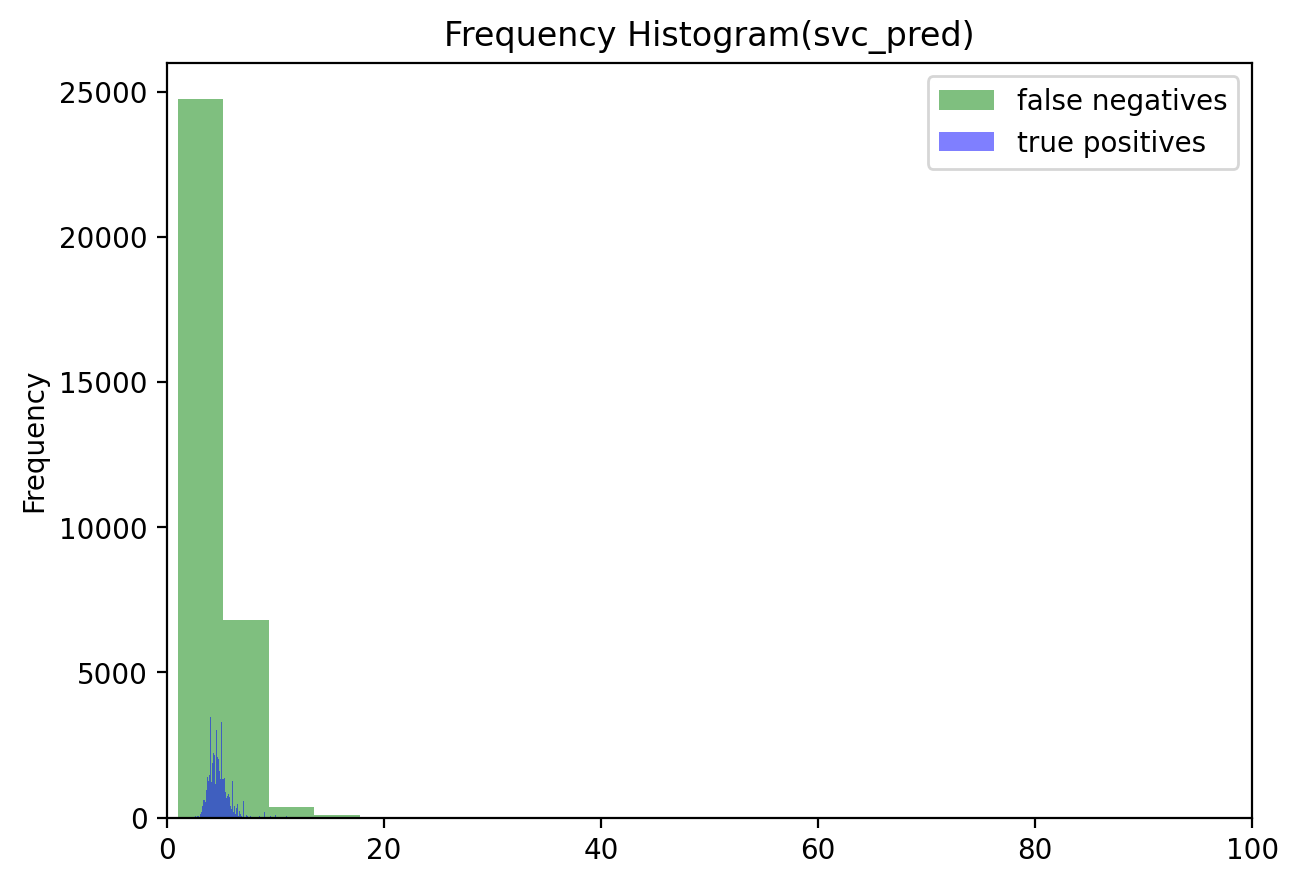

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':200})

kwargs = dict(alpha=0.5, bins=500)

plt.hist(FN['avg_word_length'], **kwargs, color='g', label='false negatives')
plt.hist(TP['avg_word_length'], **kwargs, color='b', label='true positives')



# Plot Histogram on x
plt.gca().set(title='Frequency Histogram(svc_pred)', ylabel='Frequency')
plt.legend(loc="upper right")
plt.xlim(xmin=0,xmax=100)

(0.0, 100.0)

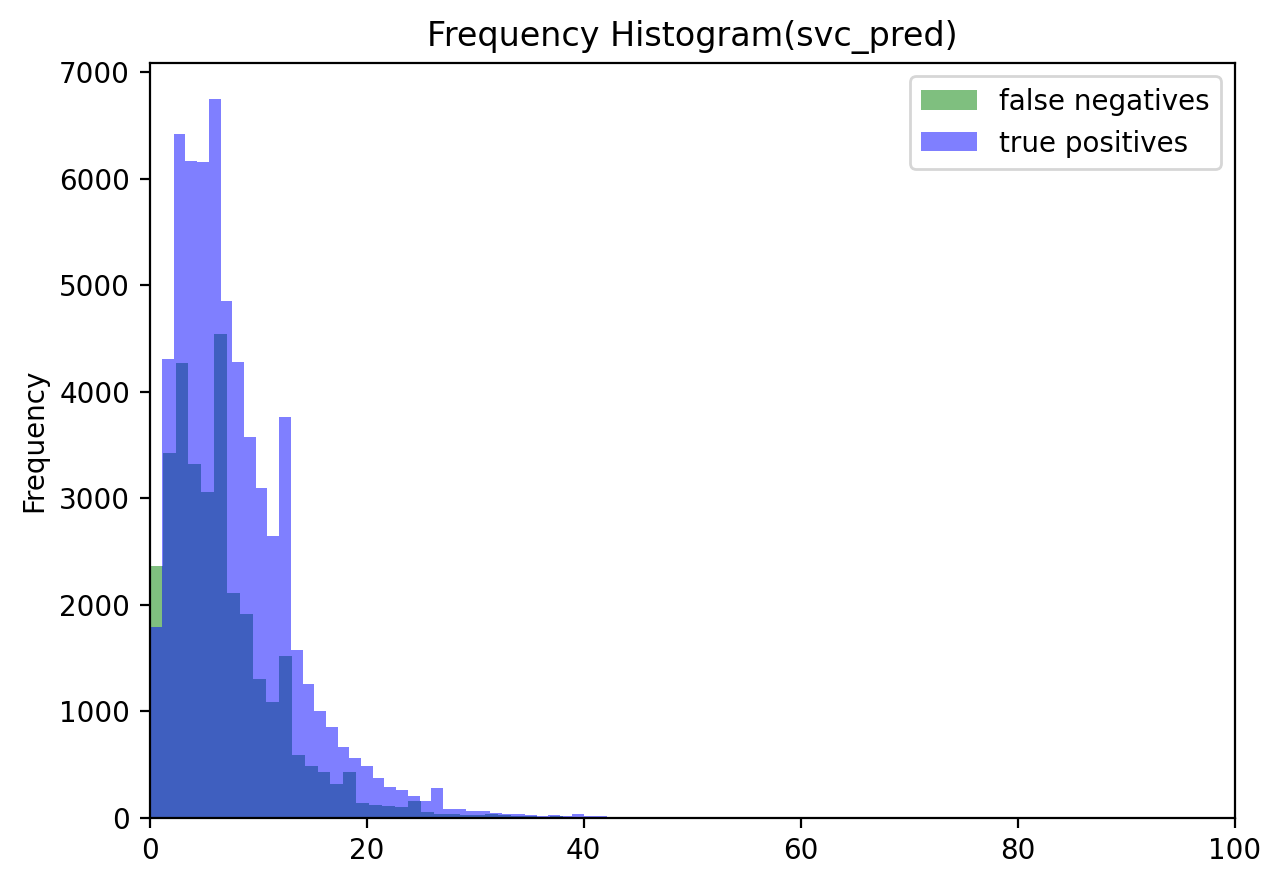

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':200})

kwargs = dict(alpha=0.5, bins=100)

plt.hist(FN['avg_sentence_length'], **kwargs, color='g', label='false negatives')
plt.hist(TP['avg_sentence_length'], **kwargs, color='b', label='true positives')



# Plot Histogram on x
plt.gca().set(title='Frequency Histogram(svc_pred)', ylabel='Frequency')
plt.legend(loc="upper right")
plt.xlim(xmin=0,xmax=100)